# Analysis of Alabama


## Required Packages

In [25]:
# For working with graphs
import networkx as nx
# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrchain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# So everyone uses the same randomness
import random

import maup


Read the shapefile data into a geodata frame and a graph.

In [26]:
# Read shapefile data into a geo data frame and a graph
al_gdf = gpd.read_file("al_precinct_file/Alabama_precincts_with_data.shp")
al_graph = Graph.from_file("al_precinct_file/Alabama_precincts_with_data.shp", ignore_errors=True)

/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1805, 1814), (1776, 1787), (99, 100), (274, 1044), (687, 697), (1178, 1182), (1787, 1802), (1798, 1802), (1806, 1815), (949, 953), (369, 378), (449, 725), (1827, 1838), (1830, 1843), (1569, 1579), (709, 730), (977, 1048), (386, 952), (1580, 1588), (797, 1099), (181, 1495), (1804, 1827), (1097, 1220), (154, 166), (80, 378), (229, 367), (513, 1685), (1780, 1789), (1793, 1817), (1816, 1819), (225, 235), (687, 1074), (272, 1070), (1794, 1809), (183, 1806), (158, 172), (365, 385), (183, 1815), (457, 468), (1476, 1490), (276, 304), (105, 175), (269, 277), (1806, 1810), (77, 85), (953, 1476), (316, 1926), (310, 1855), (469, 698), (302, 1106), (469, 716), (1532, 1534), (302, 1115), (472, 1792), (1167, 1274), (1789, 1824), (1823, 1835), (702, 704), (690, 711), (501, 543), (246, 253), (1774, 1808), (1782, 1821), (545, 558), (294,

In [33]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
al_gdf

senate_columns = ["G22USSDBOY", "G22USSLSOP", "G22USSOWRI", "G22USSRBRI"]
print(al_gdf.columns)

al_gdf["Original_CD"] = al_gdf["OriginalPl"]
al_gdf["Adopted_CD"] = al_gdf["AdoptedPla"]
al_gdf.drop(columns=["OriginalPl", "AdoptedPla"])

print(al_gdf.columns)

al_graph = Graph.from_geodataframe(al_gdf, ignore_errors=True)


Index(['UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'G22USSDBOY',
       'G22USSLSOP', 'G22USSOWRI', 'G22USSRBRI', 'OriginalPl', 'AdoptedPla',
       'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N', 'P1_006N',
       'P1_007N', 'P1_008N', 'geometry', 'Original_CD', 'Adopted_CD'],
      dtype='object')
Index(['UNIQUE_ID', 'COUNTYFP', 'County', 'Precinct', 'G22USSDBOY',
       'G22USSLSOP', 'G22USSOWRI', 'G22USSRBRI', 'OriginalPl', 'AdoptedPla',
       'P1_001N', 'P1_002N', 'P1_003N', 'P1_004N', 'P1_005N', 'P1_006N',
       'P1_007N', 'P1_008N', 'geometry', 'Original_CD', 'Adopted_CD'],
      dtype='object')


/opt/anaconda3/envs/Math195/lib/python3.12/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1805, 1814), (1776, 1787), (99, 100), (274, 1044), (687, 697), (1178, 1182), (1787, 1802), (1798, 1802), (1806, 1815), (949, 953), (369, 378), (449, 725), (1827, 1838), (1830, 1843), (1569, 1579), (709, 730), (977, 1048), (386, 952), (1580, 1588), (797, 1099), (181, 1495), (1804, 1827), (1097, 1220), (154, 166), (80, 378), (229, 367), (513, 1685), (1780, 1789), (1793, 1817), (1816, 1819), (225, 235), (687, 1074), (272, 1070), (1794, 1809), (183, 1806), (158, 172), (365, 385), (183, 1815), (457, 468), (1476, 1490), (276, 304), (105, 175), (269, 277), (1806, 1810), (77, 85), (953, 1476), (316, 1926), (310, 1855), (469, 698), (302, 1106), (469, 716), (1532, 1534), (302, 1115), (472, 1792), (1167, 1274), (1789, 1824), (1823, 1835), (702, 704), (690, 711), (501, 543), (246, 253), (1774, 1808), (1782, 1821), (545, 558), (294,

<Axes: >

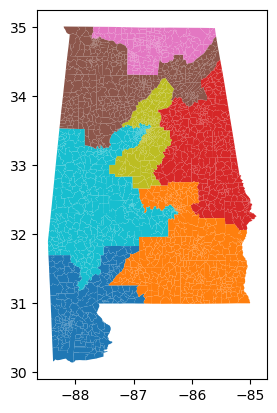

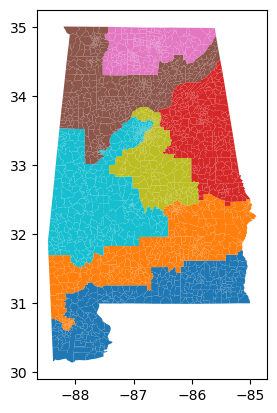

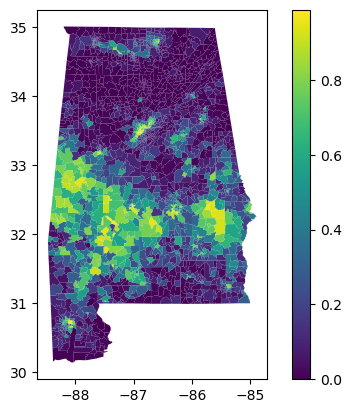

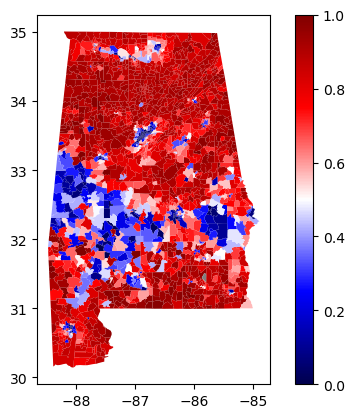

In [40]:
# Make a distrcting plan, using the CD column
original_plan = GeographicPartition(al_graph, assignment = "Original_CD")

# Draw the map of the districting plan
al_gdf.plot(column = 'Original_CD', cmap = 'tab10')

# Draw the map of the new districting plan
al_gdf.plot(column = "Adopted_CD", cmap = 'tab10')

# Plot the black population percentage by precincts
al_gdf['b_frac'] = pd.to_numeric(al_gdf['P1_004N'])/pd.to_numeric(al_gdf['P1_001N'])
al_gdf.plot(column = 'b_frac', missing_kwds = {"color":"grey"}, legend=True)

# Color units based on Democratic majority

# Plot the senate republican votes by precincts
al_gdf['pref_party'] = pd.to_numeric(al_gdf['G22USSRBRI'])/pd.to_numeric(al_gdf["G22USSDBOY"] + al_gdf["G22USSLSOP"] + al_gdf["G22USSOWRI"] + al_gdf["G22USSRBRI"])
al_gdf.plot(column = 'pref_party', missing_kwds = {"color":"grey"}, cmap = "seismic", legend=True)